In [1]:
import numpy as np
import pandas as pd
import scipy
import sys

sys.path.append("..")
from helpers import filename_for
from plotconf import *

Welcome to JupyROOT 6.16/00


In [2]:
label = "nPN"
neutrons = range(1, 7)
expdist = [20, 10, 30, 40, 0, 0]

In [3]:
files = [filename_for(15, 30, 600, 500, n, "inclxx", s, "trifeature.parquet") for n in neutrons for s in range(20)]
dfs = [pd.read_parquet(file) for file in files]
data = pd.concat(dfs, ignore_index=True)

In [4]:
hits = [np.histogram(data[data[label] == n]["nHits"], range=(0, 150), bins=150, density=True)[0] for n in neutrons]
clus = [np.histogram(data[data[label] == n]["nClus"], range=(0, 150), bins=150, density=True)[0] for n in neutrons]
edep = [np.histogram(data[data[label] == n]["Edep"], range=(0, 2000), bins=200, density=True)[0] for n in neutrons]
for i in neutrons:
    hits[i-1][0] = 0
    clus[i-1][0] = 0
    edep[i-1][0] = 0

In [5]:
# Create "experimental" spectra
exphits = np.dot(expdist, hits)
expclus = np.dot(expdist, clus)
expedep = np.dot(expdist, edep)

In [6]:
# Determine "experimental" multiplicity distributions
def fun(x):
    fithits = np.dot(x, hits)
    fitclus = np.dot(x, clus)
    fitedep = np.dot(x, edep)
    return np.sum((exphits - fithits) ** 2) + np.sum((expclus - fitclus) ** 2) + np.sum((expedep - fitedep) ** 2)


result = scipy.optimize.minimize(
    fun, [1, 1, 1, 1, 1, 1], bounds=[(0, None), (0, None), (0, None), (0, None), (0, None), (0, None)]
)
print(result)

print(list(zip(np.round(result["x"], 5), expdist)))

      fun: 1.5123838989285824e-10
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.95210109e-06, -3.90072453e-06, -1.46980435e-06,  1.08573739e-06,
        3.34640105e-06,  4.30167903e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 175
      nit: 21
   status: 0
  success: True
        x: array([2.00000004e+01, 9.99995049e+00, 3.00000888e+01, 3.99998551e+01,
       1.19095222e-04, 0.00000000e+00])
[(20.0, 20), (9.99995, 10), (30.00009, 30), (39.99986, 40), (0.00012, 0), (0.0, 0)]


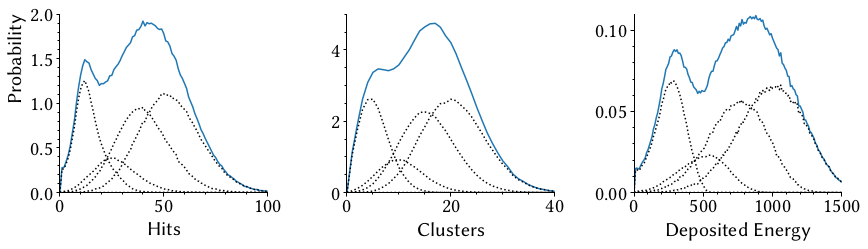

In [7]:
fig = plt.figure(figsize=(2 * 6.224, 2 * (6.224 / 1.618 * 0.5)))

ax1 = fig.add_subplot(131)
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 2)
ax1.plot(exphits)
for i in neutrons:
    ax1.plot(result["x"][i-1]*hits[i-1], color="black", linestyle=":")
ax1.set_ylabel(r"Probability", horizontalalignment="right", y=1)
ax1.set_xlabel(r"Hits")

ax2 = fig.add_subplot(132)
ax2.set_xlim(0, 40)
ax2.set_ylim(0, 5)
ax2.plot(expclus)
for i in neutrons:
    ax2.plot(result["x"][i-1]*clus[i-1], color="black", linestyle=":")
ax2.set_xlabel(r"Clusters")

ax3 = fig.add_subplot(133)
tx = [x*10 for x in range(len(expedep))]
ax3.plot(tx, expedep)
ax3.set_xlim(0, 1500)
ax3.set_ylim(0, 0.11)
for i in neutrons:
    ax3.plot(tx, result["x"][i-1]*edep[i-1], color="black", linestyle=":")
ax3.set_xlabel(r"Deposited Energy")

fig.tight_layout()
display(fig)